# Imports

In [403]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [ ]:
def extract_dish(img):
    """Extract a square crop that contains the Petri dish from a grayscale image.

    Uses Otsu thresholding to segment the image, then scores connected
    components by size, squareness, and proximity to the image center to
    choose the dish before returning a padded square crop.
    """
    # height, widh, center of image
    height, widh = img.shape
    center = (widh // 2, height // 2)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - center[0], cy - center[1]])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Petri dish is fully inside margin is added
    margin = 40
    x_m = max(x - margin, 0)
    y_m = max(y - margin, 0)

    # crop
    side = min(w, h)
    x2 = x + side + margin
    y2 = y + side + margin
    crop = img[y_m:y2, x_m:x2]

    # check crop is square
    assert crop.shape[0] == crop.shape[1], "Crop is not square!"
    return crop

# Attempt 1

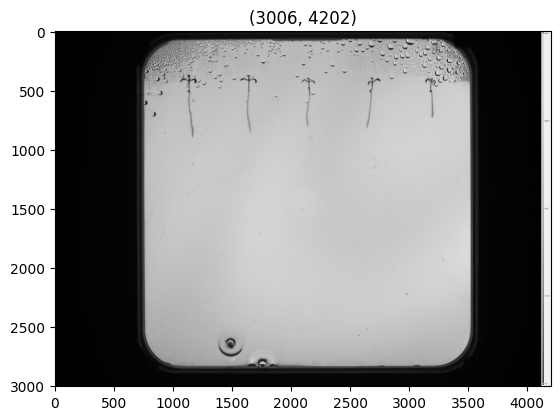

In [405]:
img_1  = cv2.imread("task_3_image_1.png")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

# Display
plt.title(str(img_1.shape))
plt.imshow(img_1, cmap='gray')
plt.show()

In [406]:
im_1 = extract_dish(img_1)

Otsu algorithm selected the following threshold: 102.0


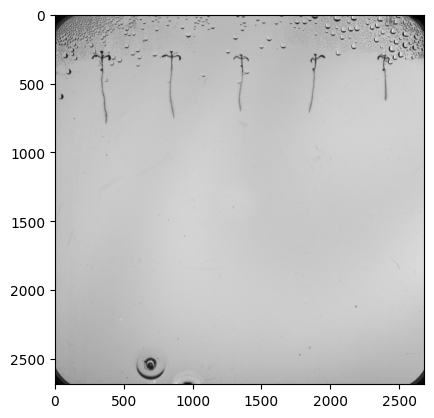

In [407]:
plt.imshow(im_1, cmap='gray')

In [408]:
im_1.shape

(2684, 2684)

In [409]:
# Otsu threshold used to separate Petri dish form backgroud (even after extraction the backgroud is visible).
# the largest connected component is the plate == plate_mask

# Otsu thresholding + connected components
th, plate_bin = cv2.threshold(im_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(plate_bin)

# Petri dish mask 
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

plate_mask = (labels == largest_label).astype(np.uint8) * 255

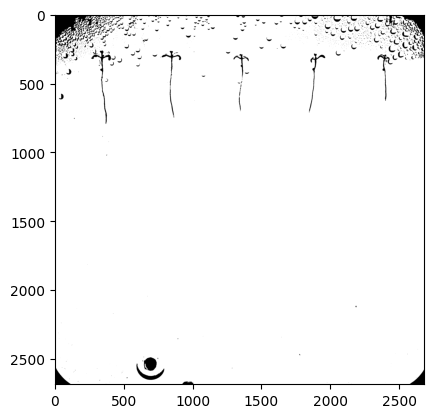

In [410]:
# white == Petri dish
plt.imshow(plate_mask, cmap='gray')

[getStructuringElement](https://docs.opencv.org/3.4/d4/d76/tutorial_js_morphological_ops.html)

In [411]:
# take into consideration only the area inside the Petri dish (will strengthen the plant features)
masked_image = cv2.bitwise_and(im_1, plate_mask)

# gaussian blur
blur = cv2.GaussianBlur(masked_image, (5,5), 0)

# Morphological closing with a large SE to estimate smooth background
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (51, 51))
closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, se)

# extract objects from the background (morphology closing - blured image)
blackhat = closed - blur

# normalize
bh_norm = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Otsu thresholding
th_o, binary = cv2.threshold(bh_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# since roots are bearly visible, the treshold is lowered to include more pixels (on choosen otrsu threshold were problem with roots visibility)
thr = int(0.55 * th_o) # 55% of Otsu selected threshold

th, plant_bin = cv2.threshold(bh_norm, thr, 255, cv2.THRESH_BINARY)

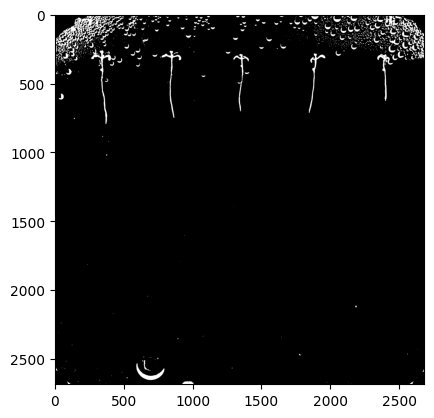

In [412]:
plt.imshow(plant_bin, cmap='gray')

In [413]:
h, w = plant_bin.shape
num, labs, stats, cents = cv2.connectedComponentsWithStats(plant_bin)

min_area = 80 # adjust size of the blob
n_plants = 5 # 5 plants per image
top_fraction = 0.65

candidates = []
for lab in range(1, num):
    x, y, ww, hh, area = stats[lab]
    if area < min_area:
        continue
    candidates.append((lab, area, x, y, ww, hh))
    
if not candidates:
    np.zeros_like(plant_bin, dtype=np.int32)

# vertical bands based on all foreground pixels
ys, xs = np.nonzero(plant_bin)
x_min, x_max = xs.min(), xs.max()
band_edges = np.linspace(x_min, x_max, n_plants + 1, dtype=int) # + 1 - background

plants_labels = []
for b in range(n_plants):
        x0, x1 = band_edges[b], band_edges[b + 1]
        best_lab = None
        best_score = -1

        for lab, area, x, y, ww, hh in candidates:
            cx, cy = cents[lab]

            # must overlap band
            if x1 <= x or x + ww <= x0:
                continue
            # keep only components whose centroid is in upper part
            if cy > h * top_fraction:
                continue

            # score: encourage tall & big regions
            score = area * hh
            if score > best_score:
                best_score = score
                best_lab = lab

        plants_labels.append(best_lab)

# puting all together into one image
inst_labels = np.zeros_like(plant_bin, dtype=np.int32)
for i, lab in enumerate(plants_labels, start=1):
    if lab is None:
        continue
    inst_labels[labs == lab] = i

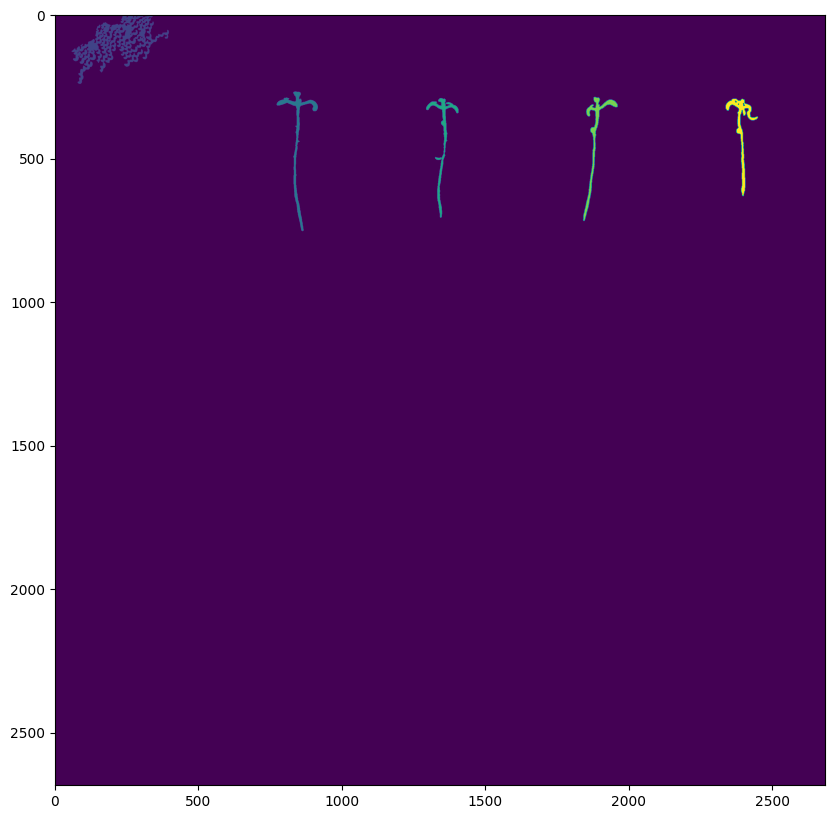

In [414]:
plt.figure(figsize=(10,10))
plt.imshow(inst_labels, cmap='viridis')

# Attempt 2

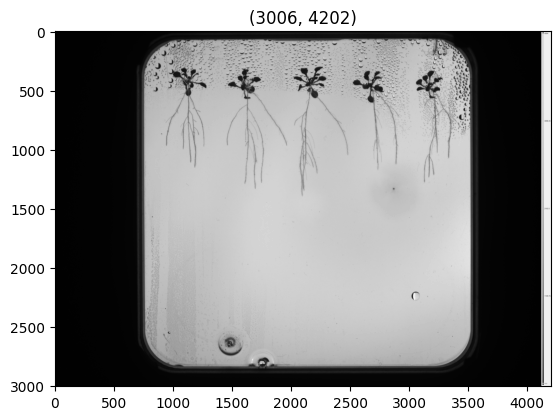

In [415]:
img_2  = cv2.imread("task_3_image_2.png")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

# Display
plt.title(str(img_2.shape))
plt.imshow(img_2, cmap='gray')
plt.show()

In [416]:
im_2 = extract_dish(img_2)

Otsu algorithm selected the following threshold: 101.0


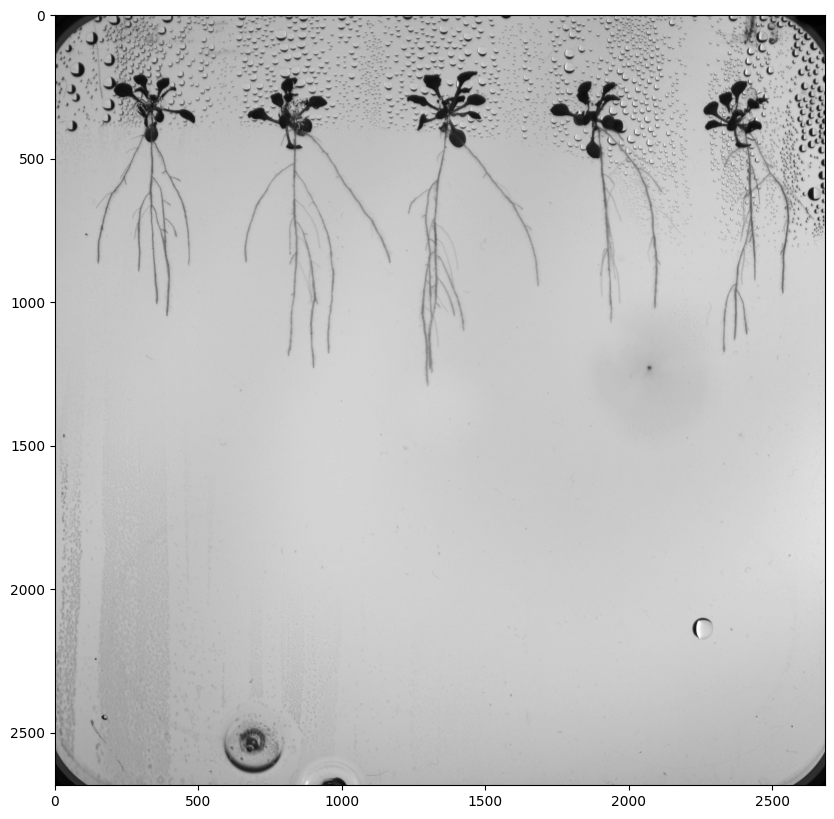

In [417]:
plt.figure(figsize=(10,10))
plt.imshow(im_2, cmap='gray')

## Attempt 1

In [418]:
# Reshape the image to a 2D array of pixels
pixels = im_2.reshape((-1, 1)).astype(np.float32)

# Convert pixel values to float
pixels = np.float32(pixels)

# Define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3  # You can adjust the number of clusters as needed
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8-bit values
centers = np.uint8(centers)

# Map the labels to their corresponding center values
segmented_image = centers[labels.flatten()]

# Reshape back to the original image shape
segmented_image = segmented_image.reshape(im_2.shape)

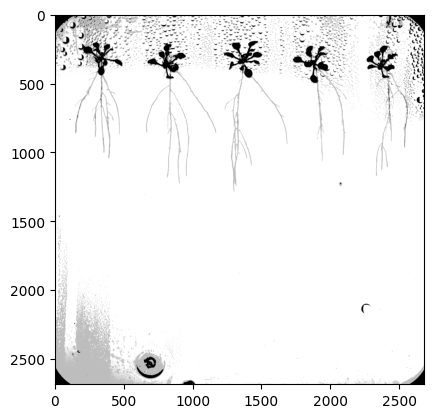

In [419]:
plt.imshow(segmented_image, cmap='gray')

## Attempt

In [420]:
# Otsu threshold used to separate Petri dish form backgroud (even after extraction the backgroud is visible).
# the largest connected component is the plate == plate_mask

# Otsu thresholding + connected components
th, plate_bin = cv2.threshold(im_2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(plate_bin)

# Petri dish mask 
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

plate_mask = (labels == largest_label).astype(np.uint8) * 255

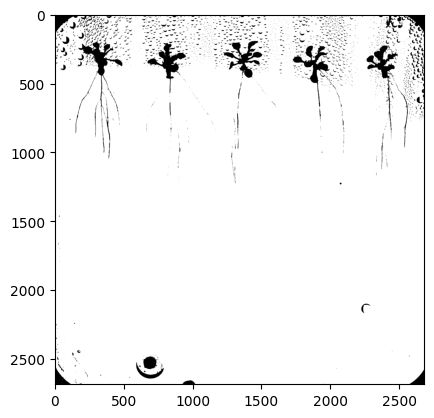

In [421]:
plt.imshow(plate_mask, cmap='gray')

In [422]:
# take into consideration only the area inside the Petri dish (will strengthen the plant features)
masked_image = cv2.bitwise_and(im_2, im_2, mask=plate_mask)

# gaussian blur
blur = cv2.GaussianBlur(masked_image, (5,5), 0)

# Morphological closing with a large SE to estimate smooth background
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (51, 51))
closed = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, se)

# extract objects from the background (morphology closing - blured image)
blackhat = closed - blur

# normalize
bh_norm = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Otsu thresholding
th_o, binary = cv2.threshold(bh_norm, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# since roots are bearly visible, the treshold is lowered to include more pixels (on choosen otrsu threshold were problem with roots visibility)
thr = int(0.55 * th_o) # 55% of Otsu selected threshold

th, plant_bin = cv2.threshold(bh_norm, thr, 255, cv2.THRESH_BINARY)

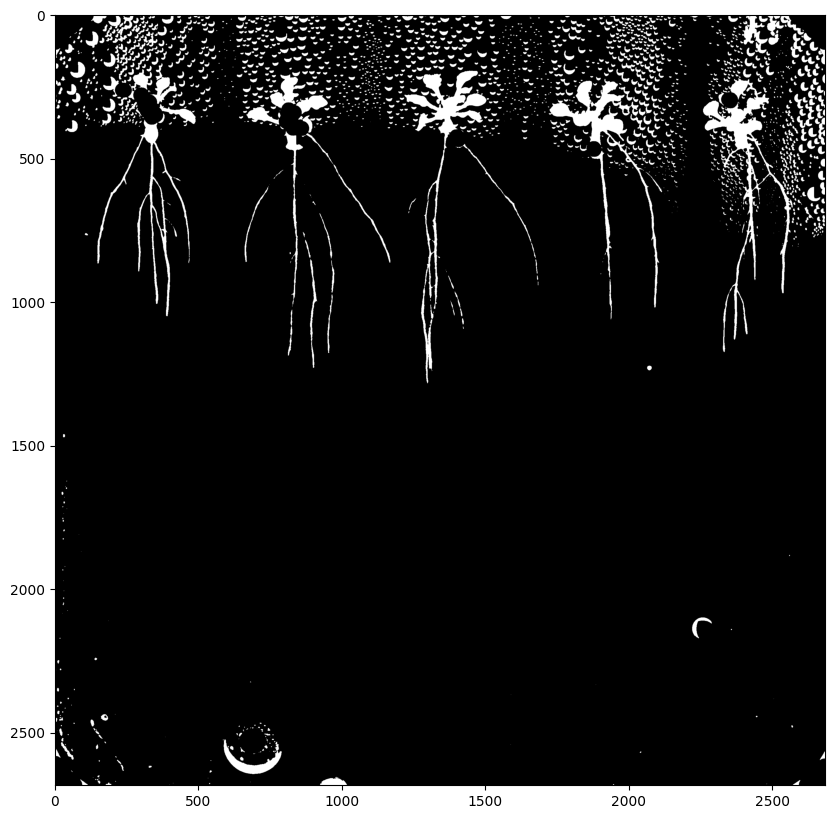

In [423]:
plt.figure(figsize=(10,10))
plt.imshow(plant_bin, cmap='gray')

In [424]:
h, w = plant_bin.shape
num, labs, stats, cents = cv2.connectedComponentsWithStats(plant_bin)

min_area = 80 # adjust size of the blob
n_plants = 5 # 5 plants per image
top_fraction = 0.65

candidates = []
for lab in range(1, num):
    x, y, ww, hh, area = stats[lab]
    if area < min_area:
        continue
    candidates.append((lab, area, x, y, ww, hh))
    
if not candidates:
    np.zeros_like(plant_bin, dtype=np.int32)

# vertical bands based on all foreground pixels
ys, xs = np.nonzero(plant_bin)
x_min, x_max = xs.min(), xs.max()
band_edges = np.linspace(x_min, x_max, n_plants + 1, dtype=int) # + 1 - background

plants_labels = []
for b in range(n_plants):
        x0, x1 = band_edges[b], band_edges[b + 1]
        best_lab = None
        best_score = -1

        for lab, area, x, y, ww, hh in candidates:
            cx, cy = cents[lab]

            # must overlap band
            if x1 <= x or x + ww <= x0:
                continue
            # keep only components whose centroid is in upper part
            # if cy > h * top_fraction:
            #     continue

            # score: encourage tall & big regions
            score = area * hh
            if score > best_score:
                best_score = score
                best_lab = lab

        plants_labels.append(best_lab)

# puting all together into one image
inst_labels = np.zeros_like(plant_bin, dtype=np.int32)
for i, lab in enumerate(plants_labels, start=1):
    if lab is None:
        continue
    inst_labels[labs == lab] = i

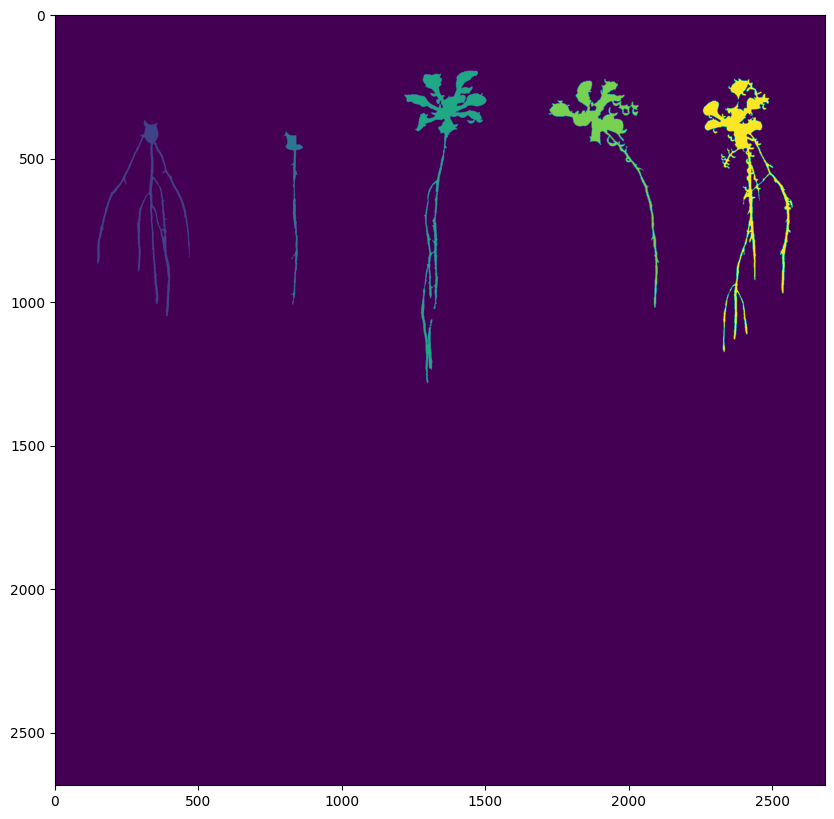

In [425]:
plt.figure(figsize=(10,10))
plt.imshow(inst_labels, cmap='viridis')

# Attempt 3

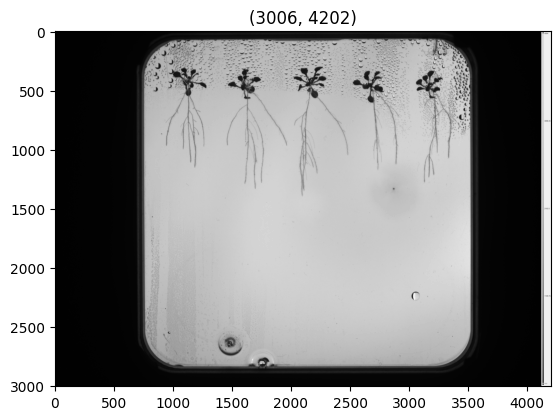

In [426]:
img_2  = cv2.imread("task_3_image_2.png")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

# Display
plt.title(str(img_2.shape))
plt.imshow(img_2, cmap='gray')
plt.show()

In [427]:
im_2 = extract_dish(img_2)

Otsu algorithm selected the following threshold: 101.0


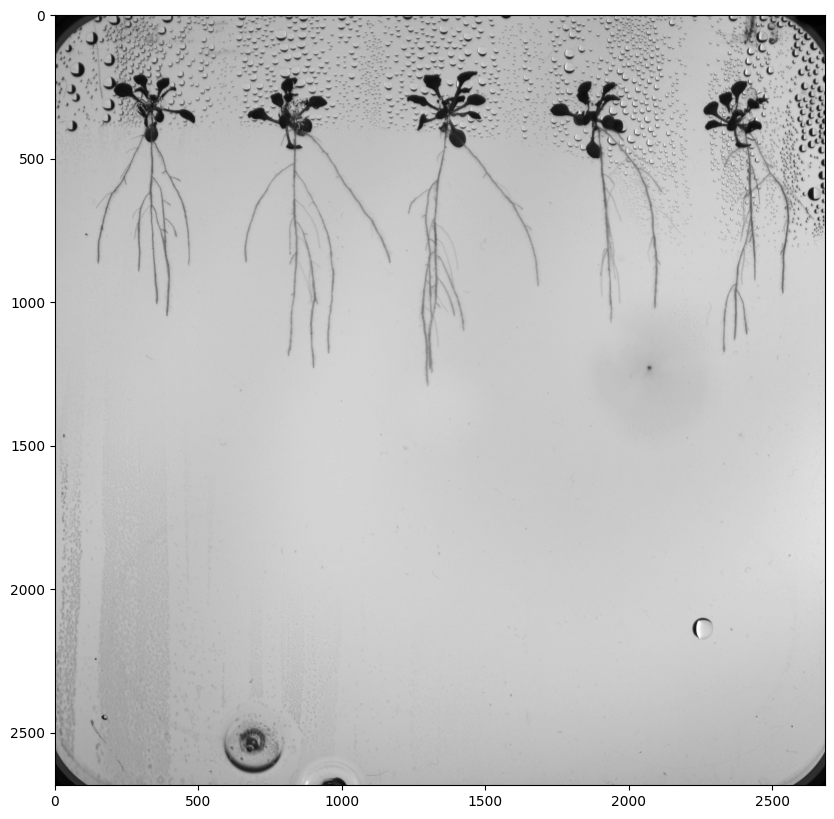

In [428]:
plt.figure(figsize=(10,10))
plt.imshow(im_2, cmap='gray')

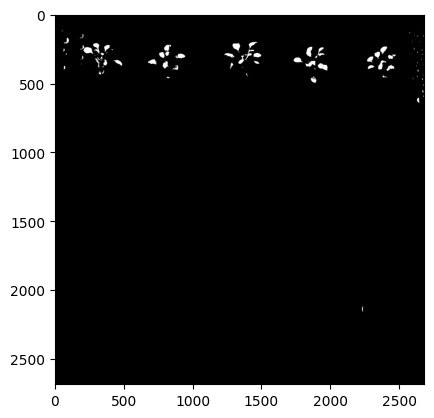

In [429]:
h, w = im_2.shape

margin = 120  # you can tune this
bottom_margin = 300
inner = np.zeros_like(im_2, dtype=np.uint8)
inner[margin:h-bottom_margin, :] = 1

shoot = ((im_2 < 35) & (inner == 1)).astype(np.uint8)
plt.imshow(shoot, cmap='gray')

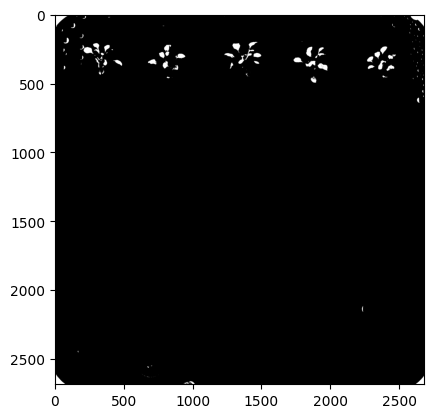

In [430]:
shoot = (im_2 < 35).astype(np.uint8)
plt.imshow(shoot, cmap='gray')

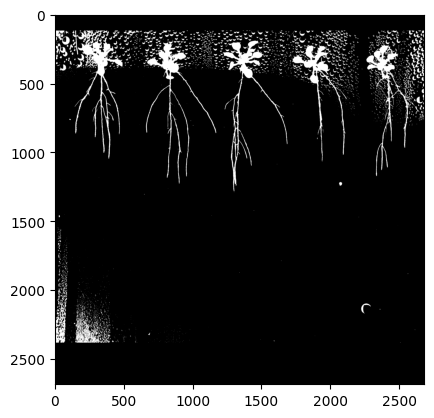

In [431]:
h, w = im_2.shape

margin = 120  # you can tune this
bottom_margin = 300
inner = np.zeros_like(im_2, dtype=np.uint8)
inner[margin:h-bottom_margin, :] = 1

roots = ((im_2 < 170) & (inner == 1)).astype(np.uint8)
plt.imshow(roots, cmap='gray')

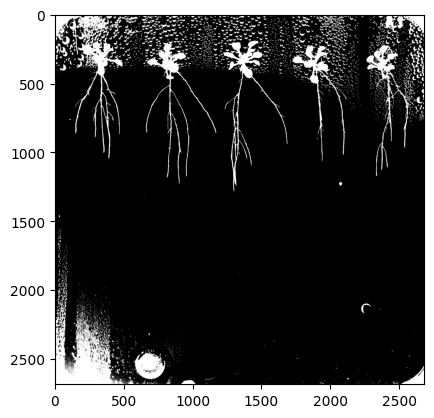

In [432]:
roots = (im_2 < 170).astype(np.uint8)
plt.imshow(roots, cmap='gray')

In [433]:
num, labs = cv2.connectedComponents(roots)
final_mask = np.zeros_like(roots, dtype=np.uint8)

for lab in range(1, num):
    component = (labs == lab)

    # If this component overlaps the strong mask â†’ it's a plant
    if np.any(shoot[component] == 1):
        final_mask[component] = 1

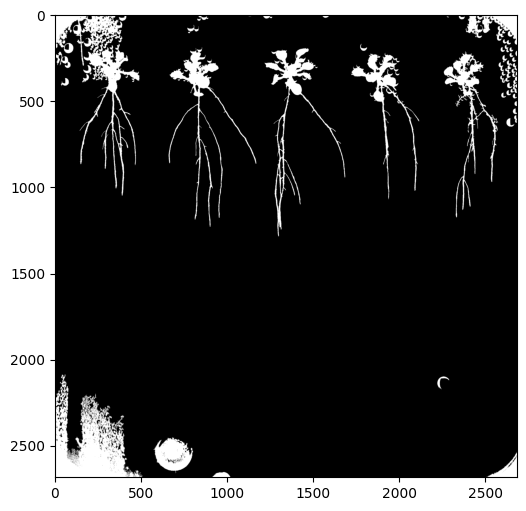

In [434]:
plt.figure(figsize=(6,6))
plt.imshow(final_mask, cmap='gray')
plt.show()

In [435]:
mask = final_mask.astype(np.uint8)
h, w = mask.shape

num, labs, stats, cents = cv2.connectedComponentsWithStats(mask)

min_area = 200     # or what you used before
min_height = 200   # tune as needed
margin = 80        # this is your "padding" idea

candidates = []

for lab in range(1, num):   # skip background 0
    x, y, ww, hh, area = stats[lab]
    cx, cy = cents[lab]

    # size filter
    if area < min_area or hh < min_height:
        continue

    # --- border / corner filter ---
    touch_left   = x <= margin
    touch_right  = x + ww >= w - margin
    touch_top    = y <= margin
    touch_bottom = y + hh >= h - margin

    # drop components in corners or along the bottom edge
    if (touch_left and touch_bottom) or (touch_right and touch_bottom) or \
       touch_bottom:
        continue

    candidates.append(lab)


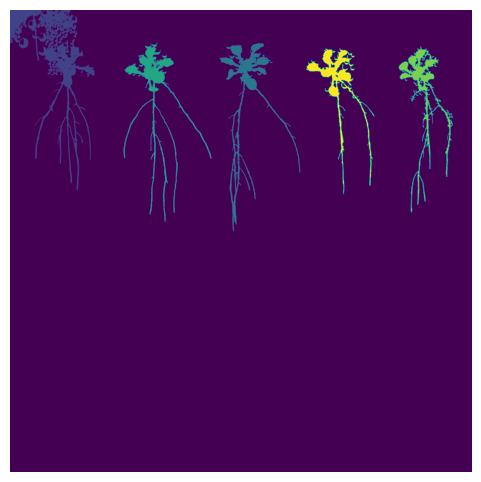

In [436]:
# sort remaining candidates by area (largest first) and keep 5
candidates_sorted = sorted(
    candidates,
    key=lambda lab: stats[lab, cv2.CC_STAT_AREA],
    reverse=True
)
plant_labels = candidates_sorted[:5]

inst_labels = np.zeros_like(labs, dtype=np.int32)
for i, lab in enumerate(plant_labels, start=1):
    inst_labels[labs == lab] = i

plt.figure(figsize=(6,6))
plt.imshow(inst_labels, cmap='viridis')
plt.axis('off')
plt.show()


In [437]:
inst_labels.shape

(2684, 2684)

# Attempt 4

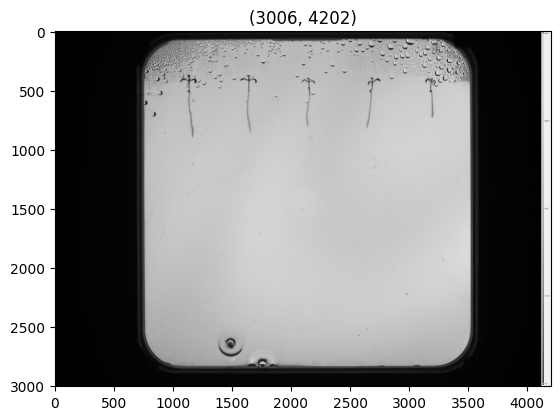

In [438]:
img_2  = cv2.imread("task_3_image_1.png")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

# Display
plt.title(str(img_2.shape))
plt.imshow(img_2, cmap='gray')
plt.show()

In [439]:
im_2 = extract_dish(img_2)

Otsu algorithm selected the following threshold: 102.0


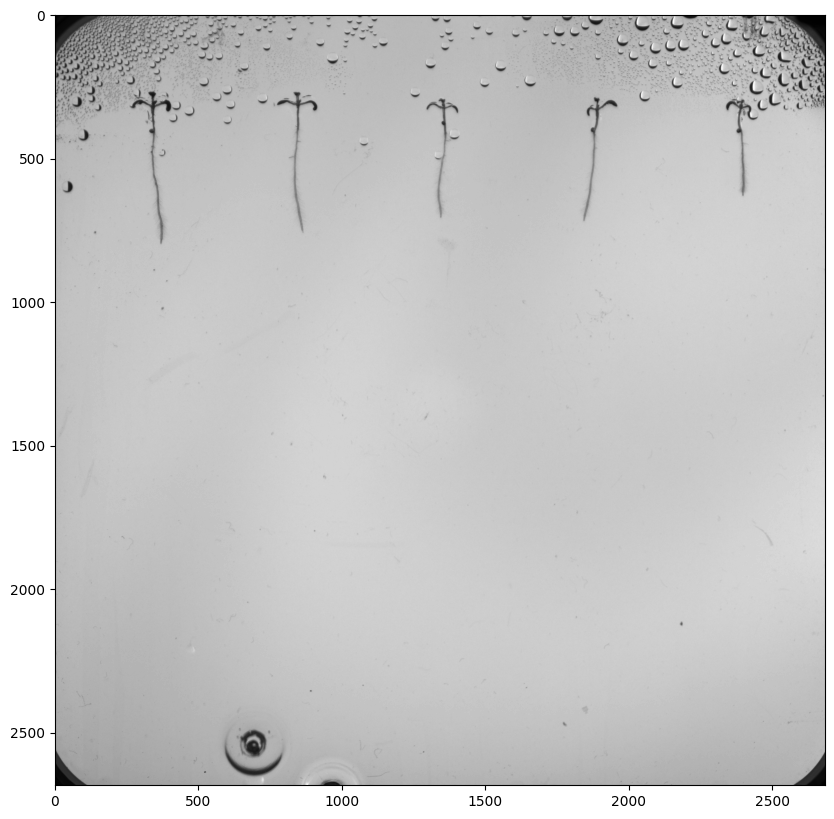

In [440]:
plt.figure(figsize=(10,10))
plt.imshow(im_2, cmap='gray')

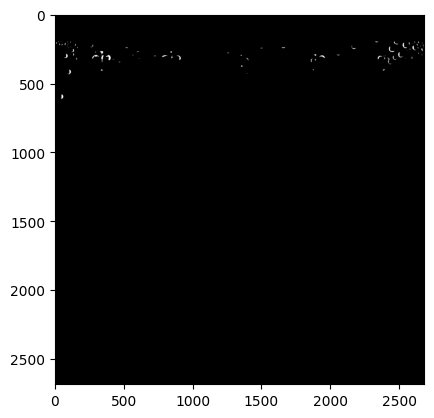

In [441]:
h, w = im_2.shape

margin = 200  # you can tune this
bottom_margin = 300
inner = np.zeros_like(im_2, dtype=np.uint8)
inner[margin:h-bottom_margin, :] = 1

shoot = ((im_2 < 60) & (inner == 1)).astype(np.uint8)
plt.imshow(shoot, cmap='gray')

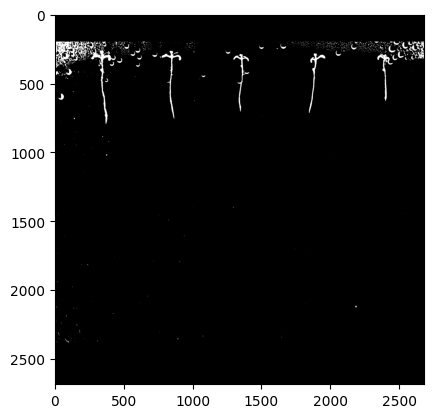

In [442]:
h, w = im_2.shape

margin = 200  # you can tune this
bottom_margin = 300
inner = np.zeros_like(im_2, dtype=np.uint8)
inner[margin:h-bottom_margin, :] = 1

roots = ((im_2 < 170) & (inner == 1)).astype(np.uint8)
plt.imshow(roots, cmap='gray')

In [443]:
num, labs = cv2.connectedComponents(roots)
final_mask = np.zeros_like(roots, dtype=np.uint8)

for lab in range(1, num):
    component = (labs == lab)

    # If this component overlaps the strong mask â†’ it's a plant
    if np.any(shoot[component] == 1):
        final_mask[component] = 1

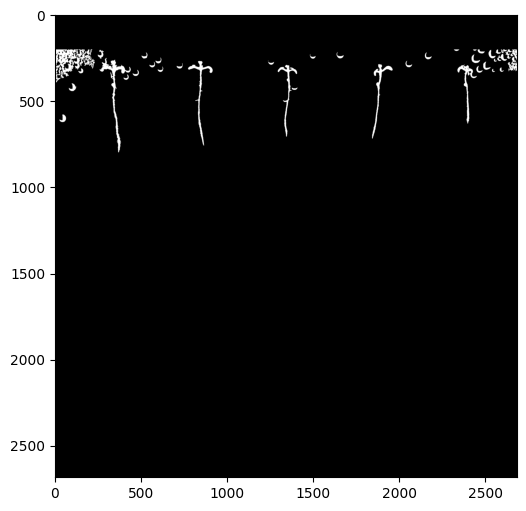

In [444]:
plt.figure(figsize=(6,6))
plt.imshow(final_mask, cmap='gray')
plt.show()

In [445]:
mask = final_mask.astype(np.uint8)
h, w = mask.shape

num, labs, stats, cents = cv2.connectedComponentsWithStats(mask)

min_area = 200     # or what you used before
min_height = 200   # tune as needed
margin = 80        # this is your "padding" idea

candidates = []

for lab in range(1, num):   # skip background 0
    x, y, ww, hh, area = stats[lab]
    cx, cy = cents[lab]

    # size filter
    if area < min_area or hh < min_height:
        continue

    # --- border / corner filter ---
    touch_left   = x <= margin
    touch_right  = x + ww >= w - margin
    touch_top    = y <= margin
    touch_bottom = y + hh >= h - margin

    # drop components in corners or along the bottom edge
    if (touch_left and touch_bottom) or (touch_right and touch_bottom) or \
       touch_bottom:
        continue

    candidates.append(lab)


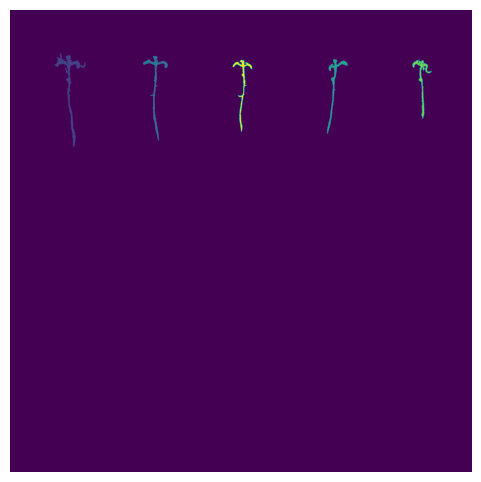

In [446]:
# sort remaining candidates by area (largest first) and keep 5
candidates_sorted = sorted(
    candidates,
    key=lambda lab: stats[lab, cv2.CC_STAT_AREA],
    reverse=True
)
plant_labels = candidates_sorted[:5]

inst_labels = np.zeros_like(labs, dtype=np.int32)
for i, lab in enumerate(plant_labels, start=1):
    inst_labels[labs == lab] = i

plt.figure(figsize=(6,6))
plt.imshow(inst_labels, cmap='viridis')
plt.axis('off')
plt.show()


# Final - wrapped in function

In [ ]:
def build_mask(img, top_margin=0, bottom_margin=0):
    """Generate a binary plant mask by combining strict shoot detection with broader root detection.

    Pixels darker than 60 are treated as shoots; pixels darker than 170 are a loose roots+shoots mask.
    Only connected components that overlap the shoot mask are kept. top_margin/bottom_margin trim rows to
    ignore image borders or plate edges.
    """
    h, _ = img.shape # only height needed

    # SHOOTS
    inner = np.zeros_like(img, dtype=np.uint8)
    # height, widh: height started from top margin (instead of 0) and end at height-bottom_margin
    inner[top_margin:h-bottom_margin, :] = 1

    shoots = ((img < 60) & (inner == 1)).astype(np.uint8) # img < 60: detect only dark pixels - shoots (sometimes some droplets)

    # ROOTS
    inner = np.zeros_like(img, dtype=np.uint8)
    # same here as for shoots mask
    inner[top_margin:h-bottom_margin, :] = 1

    roots = ((img < 170) & (inner == 1)).astype(np.uint8) # img < 170: detect dark and light grey pixels - shoots, roots (our focus) and droplets

    num, labs = cv2.connectedComponents(roots) 
    final_mask = np.zeros_like(roots, dtype=np.uint8)

    for lab in range(1, num): # skip 0 - background
        component = (labs == lab)

        # If this component overlaps the strong mask -> it's a plant
        if np.any(shoots[component] == 1):
            final_mask[component] = 1

    plt.figure(figsize=(6,6))
    plt.imshow(final_mask, cmap='gray')
    plt.show()
    return final_mask

In [ ]:
def top_5_mask(final_mask, min_area, min_height, margin):
    """Keep up to five plant instances that meet size/height thresholds and avoid edges/corners.

    Connected components are filtered by area and height, then dropped if they touch the bottom
    or bottom corners within a margin. Remaining components are sorted by area and relabeled
    1..5 for visualization.
    """
    mask = final_mask.astype(np.uint8)
    h, w = mask.shape

    num, labs, stats, cents = cv2.connectedComponentsWithStats(mask)

    candidates = []

    for lab in range(1, num):   # skip background 0
        x, y, ww, hh, area = stats[lab]

        # size filter
        # size filter is applied since we know the size of plants - reducing noises
        if area < min_area or hh < min_height:
            continue

        # --- border / corner filter ---
        # filter is aplied since we know where top of plants are - reducing noises
        touch_left   = x <= margin
        touch_right  = x + ww >= w - margin
        touch_bottom = y + hh >= h - margin

        # drop components in corners or along the bottom edge
        if (touch_left and touch_bottom) or (touch_right and touch_bottom) or touch_bottom:
            continue

        candidates.append(lab)
    
    candidates_sorted = sorted(candidates, key=lambda lab: stats[lab, cv2.CC_STAT_AREA], reverse=True)

    plant_labels = candidates_sorted[:5] # 5 plants

    inst_labels = np.zeros_like(labs, dtype=np.int32)
    for i, lab in enumerate(plant_labels, start=1):
        inst_labels[labs == lab] = i

    plt.figure(figsize=(6,6))
    plt.imshow(inst_labels, cmap='viridis')
    plt.show()

    return inst_labels

Otsu algorithm selected the following threshold: 102.0


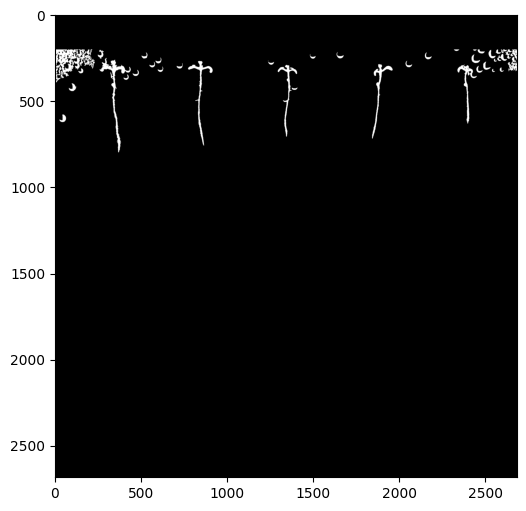

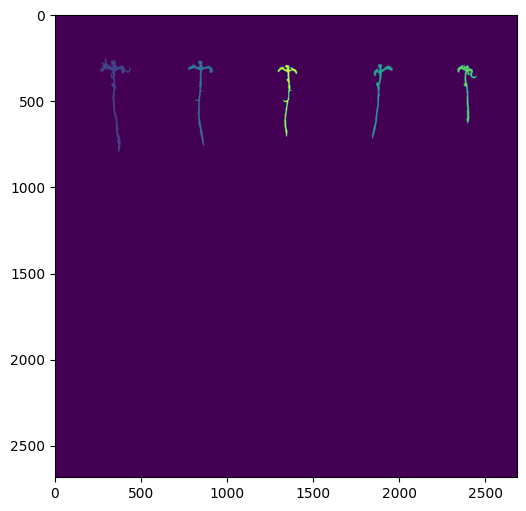

In [450]:
img_1  = cv2.imread("task_3_image_1.png")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

im_1 = extract_dish(img_1)

img_1_mask = build_mask(im_1, top_margin=200, bottom_margin=300)
img_1_plants = top_5_mask(img_1_mask, min_area=20, min_height=200, margin=80)


Otsu algorithm selected the following threshold: 101.0


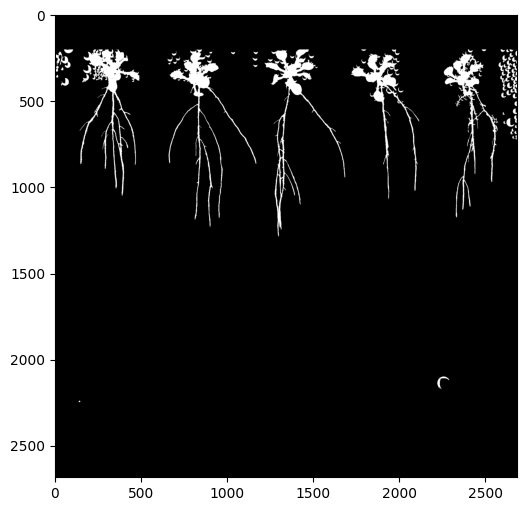

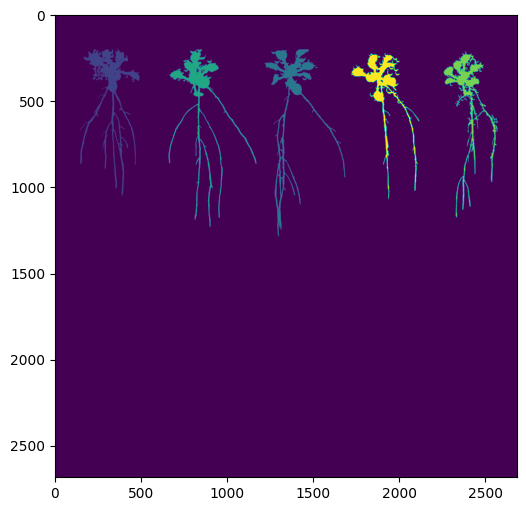

In [451]:
img_2  = cv2.imread("task_3_image_2.png")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

im_2 = extract_dish(img_2)

img_2_mask = build_mask(im_2, top_margin=200, bottom_margin=300)
img_2_plants = top_5_mask(img_2_mask, min_area=20, min_height=200, margin=80)